In [2]:
from IPython.display import YouTubeVideo

YouTubeVideo("hp4eOQmZE78", width=600, height=400)

In [ ]:
%pip install tensorflow
%pip install keras

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error



In [ ]:
# Download 60 days of data for gold. Adjust ticker if needed.
ticker = "GC=F"  
data = yf.download(ticker, period="60d", interval="15m")
print(data.head())

data.to_csv("gold_data15m.csv")


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Price                            Close         High          Low         Open  \
Ticker                            GC=F         GC=F         GC=F         GC=F   
Datetime                                                                        
2025-01-22 05:00:00+00:00  2767.199951  2768.500000  2766.500000  2768.300049   
2025-01-22 05:15:00+00:00  2768.699951  2768.899902  2766.800049  2767.300049   
2025-01-22 05:30:00+00:00  2769.699951  2770.100098  2767.899902  2768.600098   
2025-01-22 05:45:00+00:00  2772.000000  2772.300049  2769.500000  2769.699951   
2025-01-22 06:00:00+00:00  2766.199951  2772.000000  2766.199951  2771.800049   

Price                     Volume  
Ticker                      GC=F  
Datetime                          
2025-01-22 05:00:00+00:00    892  
2025-01-22 05:15:00+00:00    484  
2025-01-22 05:30:00+00:00   1128  
2025-01-22 05:45:00+00:00   2013  
2025-01-22 06:00:00+00:00   1655  


In [ ]:
# Laad de data. Dit is de csv die we eerder hebben opgeslagen.
data = pd.read_csv("gold_data15m.csv", header=[0, 1], index_col=0, parse_dates=True)

# Bekijk de originele kolommen (multi-index)
print("Original columns:")
print(data.columns)

# Maak de kolomnamen eenvoudiger: haal de eerste level ("Price") eruit
data.columns = data.columns.get_level_values(0)

print("\nCleaned data data:")
print(data.head())

# Check op missende waarden
print("\nAantal missende waarden per kolom:")
print(data.isna().sum())

Original columns:
MultiIndex([( 'Close', 'GC=F'),
            (  'High', 'GC=F'),
            (   'Low', 'GC=F'),
            (  'Open', 'GC=F'),
            ('Volume', 'GC=F')],
           names=['Price', 'Ticker'])

Cleaned data data:
Price                            Close         High          Low         Open  \
Datetime                                                                        
2025-01-22 05:00:00+00:00  2767.199951  2768.500000  2766.500000  2768.300049   
2025-01-22 05:15:00+00:00  2768.699951  2768.899902  2766.800049  2767.300049   
2025-01-22 05:30:00+00:00  2769.699951  2770.100098  2767.899902  2768.600098   
2025-01-22 05:45:00+00:00  2772.000000  2772.300049  2769.500000  2769.699951   
2025-01-22 06:00:00+00:00  2766.199951  2772.000000  2766.199951  2771.800049   

Price                      Volume  
Datetime                           
2025-01-22 05:00:00+00:00     892  
2025-01-22 05:15:00+00:00     484  
2025-01-22 05:30:00+00:00    1128  
2025-01-22 05:4

In [ ]:
# Functie om ATR te berekenen
def compute_atr(df, period=14):
    # Bereken de drie componenten
    df['H-L'] = df['High'] - df['Low']
    df['H-PC'] = abs(df['High'] - df['Close'].shift(1))
    df['L-PC'] = abs(df['Low'] - df['Close'].shift(1))
    # Kies de maximum waarde per rij
    df['TR'] = df[['H-L', 'H-PC', 'L-PC']].max(axis=1)
    # Bereken de ATR als het voortschrijdend gemiddelde van TR
    atr = df['TR'].rolling(window=period).mean()
    return atr

# Functie om RSI te berekenen
def compute_rsi(df, period=14):
    delta = df['Close'].diff()
    # Bereken winst en verlies
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Gemiddelde winst en verlies
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    # Bereken de relative sterkte
    rs = avg_gain / avg_loss
    # Bereken de RSI
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Voeg ATR en RSI toe aan de data
data['ATR'] = compute_atr(data, period=14)
data['RSI'] = compute_rsi(data, period=14)

print("Laatste rijen met berekende features:")
print(data[['Close', 'ATR', 'RSI']].tail())

Laatste rijen met berekende features:
Price                            Close        ATR        RSI
Datetime                                                    
2025-04-02 14:30:00+00:00  3164.100098  14.585711  64.130598
2025-04-02 14:45:00+00:00  3162.600098  16.407139  58.695787
2025-04-02 15:00:00+00:00  3164.300049  18.185721  63.701052
2025-04-02 15:15:00+00:00  3162.699951  18.585728  59.310176
2025-04-02 15:30:00+00:00  3140.000000  20.207153  34.468907


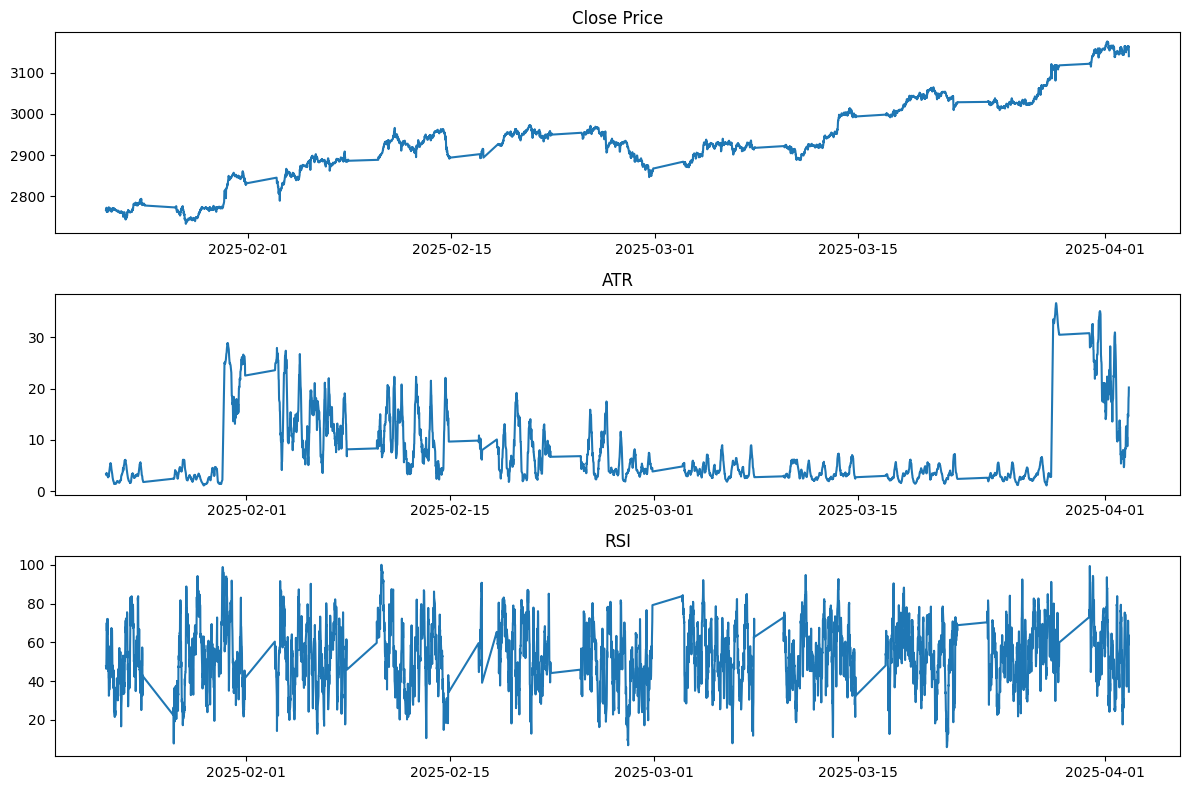

In [ ]:
plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
plt.plot(data.index, data['Close'])
plt.title('Close Price')

plt.subplot(3, 1, 2)
plt.plot(data.index, data['ATR'])
plt.title('ATR')

plt.subplot(3, 1, 3)
plt.plot(data.index, data['RSI'])
plt.title('RSI')

plt.tight_layout()
plt.show()

In [ ]:
# Definieer de target als 'ATR' van de volgende rij (voorspellen van volgende ATR)
data['Target'] = data['ATR'].shift(-1)

# Verwijder de laatste rij (die nu NaN is in 'Target') en eventuele andere missende waarden
data.dropna(inplace=True)

# Kies welke kolommen je als features wilt gebruiken
# Let op: we laten 'ATR' zelf buiten de features om geen 'lek' te hebben.
features = ['Close', 'High', 'Low', 'Open', 'Volume', 'RSI']

X = data[features]
y = data['Target']

# Voorbeeld: 80% training, 20% test. We shuffle=False omdat het een tijdreeks is.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Vorm van trainingset:", X_train.shape, y_train.shape)
print("Vorm van testset:", X_test.shape, y_test.shape)

Vorm van trainingset: (3632, 6) (3632,)
Vorm van testset: (908, 6) (908,)


In [ ]:
# Maak naïeve voorspellingen: ATR van de vorige timestep.
naive_preds = data['ATR'].shift(1)

# Vind de gemeenschappelijke index, zodat we alleen de rijen nemen zonder NaN
common_index = y.index.intersection(naive_preds.dropna().index)
naive_preds = naive_preds.loc[common_index]
y_aligned = y.loc[common_index]

# Bereken de benchmark metrics
naive_mae = mean_absolute_error(y_aligned, naive_preds)
naive_mse = mean_squared_error(y_aligned, naive_preds)

print("Naïeve benchmark MAE:", naive_mae)
print("Naïeve benchmark MSE:", naive_mse)

Naïeve benchmark MAE: 0.6631496793108044
Naïeve benchmark MSE: 1.1754467285945653


In [ ]:
# Maak en train het Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Voorspel op de testset
y_pred = rf.predict(X_test)

# Bereken evaluatiemetrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Random Forest MAE:", mae)
print("Random Forest MSE:", mse)

Random Forest MAE: 6.619070697301885
Random Forest MSE: 136.4545417564908


In [ ]:
# 1. Scale de features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Maak sequenties met een look-back periode (bijv. 10 timesteps)
look_back = 10

def create_sequences(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train.values, look_back)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test.values, look_back)

print("Vorm X_train_seq:", X_train_seq.shape)
print("Vorm y_train_seq:", y_train_seq.shape)

Vorm X_train_seq: (3622, 10, 6)
Vorm y_train_seq: (3622,)


In [ ]:
# Bouw het LSTM-model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, X_train_scaled.shape[1])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()

# Train het model
history = model.fit(
    X_train_seq, y_train_seq, 
    epochs=20, 
    batch_size=32, 
    validation_data=(X_test_seq, y_test_seq)
)

y_pred_lstm = model.predict(X_test_seq)
mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)

print("LSTM MAE:", mae_lstm)
print("LSTM MSE:", mse_lstm)

2025-04-02 17:53:19.873469: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2025-04-02 17:53:19.873497: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-04-02 17:53:19.873500: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-04-02 17:53:19.873529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-02 17:53:19.873537: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/ums/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequenti

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        11,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,451 (44.73 KB)

 Trainable params: 11,451 (44.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


2025-04-02 17:53:20.166883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


114/114 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 65.9755 - val_loss: 130.0931
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 21.6067 - val_loss: 143.6369
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 14.0352 - val_loss: 155.3369
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 6.2683 - val_loss: 134.3696
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4111 - val_loss: 136.7014
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 3.8484 - val_loss: 127.5361
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7467 - val_loss: 122.4199
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7980 - val_loss: 124.1077
Epoch 9/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.2677 - val_loss: 120.9183
Epoch 10/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.3901 - val_loss: 119.4249
Epoch 11/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9755 - val_loss: 122.0712
Epoch 12/20
114/114 ━━━━━━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Bouw een verbeterd LSTM-model
model_improved = Sequential()
# Eerste LSTM-laag met return_sequences=True zodat we een stacked LSTM kunnen bouwen
model_improved.add(LSTM(64, return_sequences=True, input_shape=(look_back, X_train_scaled.shape[1])))
model_improved.add(Dropout(0.2))
# Tweede LSTM-laag zonder return_sequences
model_improved.add(LSTM(32))
model_improved.add(Dropout(0.2))
# Output laag
model_improved.add(Dense(1))

# Compileer het model
model_improved.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model_improved.summary()

# Train het verbeterde model
history_improved = model_improved.fit(
    X_train_seq, y_train_seq, 
    epochs=40,        # Meer epochs om langer te trainen
    batch_size=32, 
    validation_data=(X_test_seq, y_test_seq)
)

# Voorspel en evalueer
y_pred_improved = model_improved.predict(X_test_seq)
mae_improved = mean_absolute_error(y_test_seq, y_pred_improved)
mse_improved = mean_squared_error(y_test_seq, y_pred_improved)

print("Improved LSTM MAE:", mae_improved)
print("Improved LSTM MSE:", mse_improved)

/Users/ums/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,625 (119.63 KB)

 Trainable params: 30,625 (119.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 68.8703 - val_loss: 120.4596
Epoch 2/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 27.7714 - val_loss: 132.0505
Epoch 3/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 17.6142 - val_loss: 123.8071
Epoch 4/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 10.4968 - val_loss: 114.8846
Epoch 5/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.2972 - val_loss: 117.0836
Epoch 6/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 6.3433 - val_loss: 100.0426
Epoch 7/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.4266 - val_loss: 103.8449
Epoch 8/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.5824 - val_loss: 99.4713
Epoch 9/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.6534 - val_loss: 93.6293
Epoch 10/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.4891 - val_loss: 97.9717
Epoch 11/40
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 3.3913 - val_loss: 92.7878
Epoch 12/40
114/114 ━━━

In [ ]:
# Zorg dat je de RF en LSTM modellen al hebt getraind.
# We moeten de RF-voorspellingen op de testset trimmen zodat ze overeenkomen met de LSTM sequentie-output.
y_pred_rf_full = rf.predict(X_test)  # lengte = aantal rijen in X_test

# Trim de eerste 'look_back' voorspellingen weg, zodat de overgebleven voorspellingen overeenkomen met y_test_seq
y_pred_rf_seq = y_pred_rf_full[look_back:]

# Zorg dat y_pred_lstm is een 1D array
y_pred_lstm_flat = y_pred_lstm.flatten()

# Combineer de voorspellingen door het gemiddelde te nemen (of pas gewichten toe indien gewenst)
y_pred_ensemble = (y_pred_rf_seq + y_pred_lstm_flat) / 2

# Bereken evaluatiemetrics voor het ensemble
ensemble_mae = mean_absolute_error(y_test_seq, y_pred_ensemble)
ensemble_mse = mean_squared_error(y_test_seq, y_pred_ensemble)

print("Ensemble MAE:", ensemble_mae)
print("Ensemble MSE:", ensemble_mse)

Ensemble MAE: 6.196518791754307
Ensemble MSE: 121.20877732389943


In [ ]:
# We veronderstellen dat y_pred_rf_seq (van RF) en y_pred_lstm_flat (van LSTM) al bestaan.
# Let op: y_pred_rf_seq is de RF-voorspelling op X_test, getrimd voor look_back,
# en y_pred_lstm_flat is de 1D array met LSTM-voorspellingen.

best_mae = float("inf")
best_weights = (0, 1)
results = []

# We variëren de RF-gewicht van 0 tot 1 in stappen van 0.1.
for weight_rf in np.linspace(0, 1, 11):
    weight_lstm = 1 - weight_rf
    # Combineer de voorspellingen met de gekozen gewichten
    ensemble_pred = weight_rf * y_pred_rf_seq + weight_lstm * y_pred_lstm_flat
    mae = mean_absolute_error(y_test_seq, ensemble_pred)
    mse = mean_squared_error(y_test_seq, ensemble_pred)
    results.append((weight_rf, weight_lstm, mae, mse))
    print(f"RF weight: {weight_rf:.2f}, LSTM weight: {weight_lstm:.2f} => MAE: {mae:.4f}, MSE: {mse:.4f}")
    if mae < best_mae:
        best_mae = mae
        best_weights = (weight_rf, weight_lstm)

print(f"\nBeste combinatie: RF weight {best_weights[0]:.2f}, LSTM weight {best_weights[1]:.2f} met MAE {best_mae:.4f}")

RF weight: 0.00, LSTM weight: 1.00 => MAE: 5.8145, MSE: 106.0327
RF weight: 0.10, LSTM weight: 0.90 => MAE: 5.8795, MSE: 108.9437
RF weight: 0.20, LSTM weight: 0.80 => MAE: 5.9509, MSE: 111.9168
RF weight: 0.30, LSTM weight: 0.70 => MAE: 6.0279, MSE: 114.9520
RF weight: 0.40, LSTM weight: 0.60 => MAE: 6.1093, MSE: 118.0493
RF weight: 0.50, LSTM weight: 0.50 => MAE: 6.1965, MSE: 121.2088
RF weight: 0.60, LSTM weight: 0.40 => MAE: 6.2873, MSE: 124.4303
RF weight: 0.70, LSTM weight: 0.30 => MAE: 6.3799, MSE: 127.7139
RF weight: 0.80, LSTM weight: 0.20 => MAE: 6.4750, MSE: 131.0597
RF weight: 0.90, LSTM weight: 0.10 => MAE: 6.5730, MSE: 134.4675
RF weight: 1.00, LSTM weight: 0.00 => MAE: 6.6738, MSE: 137.9375

Beste combinatie: RF weight 0.00, LSTM weight 1.00 met MAE 5.8145


In [ ]:
# Maak kopieën van X_train en X_test
X_train_with_rf = X_train.copy()
X_test_with_rf = X_test.copy()

# Voeg een kolom toe met RF-voorspellingen
X_train_with_rf['rf_pred'] = rf.predict(X_train)
X_test_with_rf['rf_pred'] = rf.predict(X_test)

print("Voorbeeld van de training data met RF voorspellingen:")
print(X_train_with_rf.head())

Voorbeeld van de training data met RF voorspellingen:
Price                            Close         High          Low         Open  \
Datetime                                                                        
2025-01-22 08:30:00+00:00  2765.899902  2767.000000  2765.100098  2765.199951   
2025-01-22 08:45:00+00:00  2766.899902  2767.100098  2764.800049  2766.000000   
2025-01-22 09:00:00+00:00  2767.699951  2769.899902  2766.699951  2766.800049   
2025-01-22 09:15:00+00:00  2772.899902  2773.300049  2767.899902  2767.899902   
2025-01-22 09:30:00+00:00  2772.800049  2773.100098  2770.699951  2772.800049   

Price                      Volume        RSI   rf_pred  
Datetime                                                
2025-01-22 08:30:00+00:00    1537  47.653296  3.440670  
2025-01-22 08:45:00+00:00    1648  46.691021  3.425730  
2025-01-22 09:00:00+00:00    1996  46.296229  3.580512  
2025-01-22 09:15:00+00:00    2152  51.504883  3.610296  
2025-01-22 09:30:00+00:00    1634  6

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler_rf = StandardScaler()
X_train_with_rf_scaled = scaler_rf.fit_transform(X_train_with_rf)
X_test_with_rf_scaled = scaler_rf.transform(X_test_with_rf)

In [ ]:
import numpy as np

look_back = 10

def create_sequences(X, y, look_back):
    X_seq, y_seq = [], []
    for i in range(len(X) - look_back):
        X_seq.append(X[i:i+look_back])
        y_seq.append(y[i+look_back])
    return np.array(X_seq), np.array(y_seq)

X_train_rf_seq, y_train_rf_seq = create_sequences(X_train_with_rf_scaled, y_train.values, look_back)
X_test_rf_seq, y_test_rf_seq = create_sequences(X_test_with_rf_scaled, y_test.values, look_back)

print("Vorm van X_train_rf_seq:", X_train_rf_seq.shape)

Vorm van X_train_rf_seq: (3622, 10, 7)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error

model_rf = Sequential()
model_rf.add(LSTM(50, input_shape=(look_back, X_train_with_rf_scaled.shape[1])))
model_rf.add(Dense(1))
model_rf.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model_rf.summary()

history_rf = model_rf.fit(
    X_train_rf_seq, y_train_rf_seq,
    epochs=20,
    batch_size=32,
    validation_data=(X_test_rf_seq, y_test_rf_seq)
)

# Evaluatie
y_pred_lstm_rf = model_rf.predict(X_test_rf_seq)
mae_lstm_rf = mean_absolute_error(y_test_rf_seq, y_pred_lstm_rf)
mse_lstm_rf = mean_squared_error(y_test_rf_seq, y_pred_lstm_rf)
print("LSTM met RF feature - MAE:", mae_lstm_rf, "MSE:", mse_lstm_rf)

/Users/ums/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 50)             │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,651 (45.51 KB)

 Trainable params: 11,651 (45.51 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 58.9753 - val_loss: 144.1077
Epoch 2/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 7.5650 - val_loss: 138.1968
Epoch 3/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 4.4465 - val_loss: 134.0911
Epoch 4/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.7343 - val_loss: 130.1233
Epoch 5/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8768 - val_loss: 130.3286
Epoch 6/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5577 - val_loss: 132.3905
Epoch 7/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.2347 - val_loss: 130.2296
Epoch 8/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0663 - val_loss: 127.3614
Epoch 9/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9721 - val_loss: 128.1322
Epoch 10/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.9976 - val_loss: 129.5134
Epoch 11/20
114/114 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9123 - val_loss: 129.6584
Epoch 12/20
114/114 ━━━━━━━━━